
# Defense Logistics Forecasting — Regression Lab (Day 1)

**In this notebook, we demonstrate:**
- loading of a tabular dataset **(CSV dataset)**.
- performin three dedicated parts for **Single**, **Double**, and **Multiple** Linear Regression.
- addition of **Ridge** and **Lasso** regression (supported with cross‑validation).
- putting extensive markdown explanations and comparisons.


In [ ]:
# importing of all necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from pandas.plotting import scatter_matrix
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, RidgeCV, LassoCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

plt.rcParams['figure.figsize'] = (5, 4)
plt.rcParams['axes.grid'] = False
plt.rcParams['figure.dpi'] = 120

DATA_PATH = "defense_logistics_dataset.csv"
df = pd.read_csv(DATA_PATH)
df.head()

,Supply_Chain_Lead_Time,Equipment_Availability,Personnel_Readiness,Transport_Efficiency,Inventory_Buffer,Maintenance_Downtime,Communication_Reliability,Operational_Tempo,Fuel_Variability,Weather_Disruption,Terrain_Transport_Interaction,Adversary_Interference,Logistics_Performance
0,12.483571,0.792618,0.939936,0.563754,19.026142,12.209084,0.804610,0.738270,0.085780,3.180641,0.051325,0.984089,6210.571994
1,9.308678,0.890942,0.892463,0.465527,22.358310,12.878423,0.856981,0.431088,0.300000,1.372687,0.015670,0.292249,5868.484176
2,13.238443,0.560143,0.805963,0.491474,15.128679,9.240638,0.879320,0.801672,0.195599,2.045223,0.003970,0.294817,4914.001181
3,17.615149,0.756297,0.735306,0.575983,19.766589,8.142470,0.994384,0.999430,0.031693,2.051198,0.129107,0.354548,5798.166096
4,8.829233,0.634936,0.869822,0.479783,12.396385,7.814573,0.927828,0.383990,0.042334,1.498216,0.111786,0.564594,4910.579969



## 1) Data Overview & Exploration

**Target**: `Logistics_Performance`  
**Predictors**: All other columns.

We start with dimensions, types, and a statistical summary, followed by a **scatter‑matrix** for the most informative features.


In [ ]:
display(df.shape)
display(df.dtypes)
df.describe().T

(500, 13)

Supply_Chain_Lead_Time           float64
Equipment_Availability           float64
Personnel_Readiness              float64
Transport_Efficiency             float64
Inventory_Buffer                 float64
Maintenance_Downtime             float64
Communication_Reliability        float64
Operational_Tempo                float64
Fuel_Variability                 float64
Weather_Disruption               float64
Terrain_Transport_Interaction    float64
Adversary_Interference           float64
Logistics_Performance            float64
dtype: object

,count,mean,std,min,25%,50%,75%,max
Supply_Chain_Lead_Time,500.0,10.080363,4.802394,1.000000,6.498463,10.063986,13.183916,29.263657
Equipment_Availability,500.0,0.703183,0.097800,0.430311,0.640471,0.702853,0.765124,0.963238
Personnel_Readiness,500.0,0.809821,0.098868,0.510374,0.739757,0.811981,0.875474,1.000000
Transport_Efficiency,500.0,0.502001,0.071678,0.237885,0.452297,0.503822,0.550969,0.707335
Inventory_Buffer,500.0,20.007432,3.699533,8.286819,17.526257,20.052173,22.549405,30.420957
Maintenance_Downtime,500.0,10.120734,2.499365,3.173092,8.423959,10.118330,11.658271,19.533779
Communication_Reliability,500.0,0.898837,0.051401,0.753528,0.863347,0.899001,0.934763,1.000000
Operational_Tempo,500.0,0.494370,0.326914,0.000101,0.179957,0.506398,0.793090,0.999991
Fuel_Variability,500.0,0.083799,0.095980,0.000001,0.010367,0.040343,0.126206,0.300000
Weather_Disruption,500.0,1.986123,1.006206,0.000000,1.242501,2.007529,2.603351,5.243093



### Scatter‑Matrix (Top Correlated Features with Target)

To keep the grid readable, we show the **top‑6 predictors** most correlated (by absolute value) with the target.


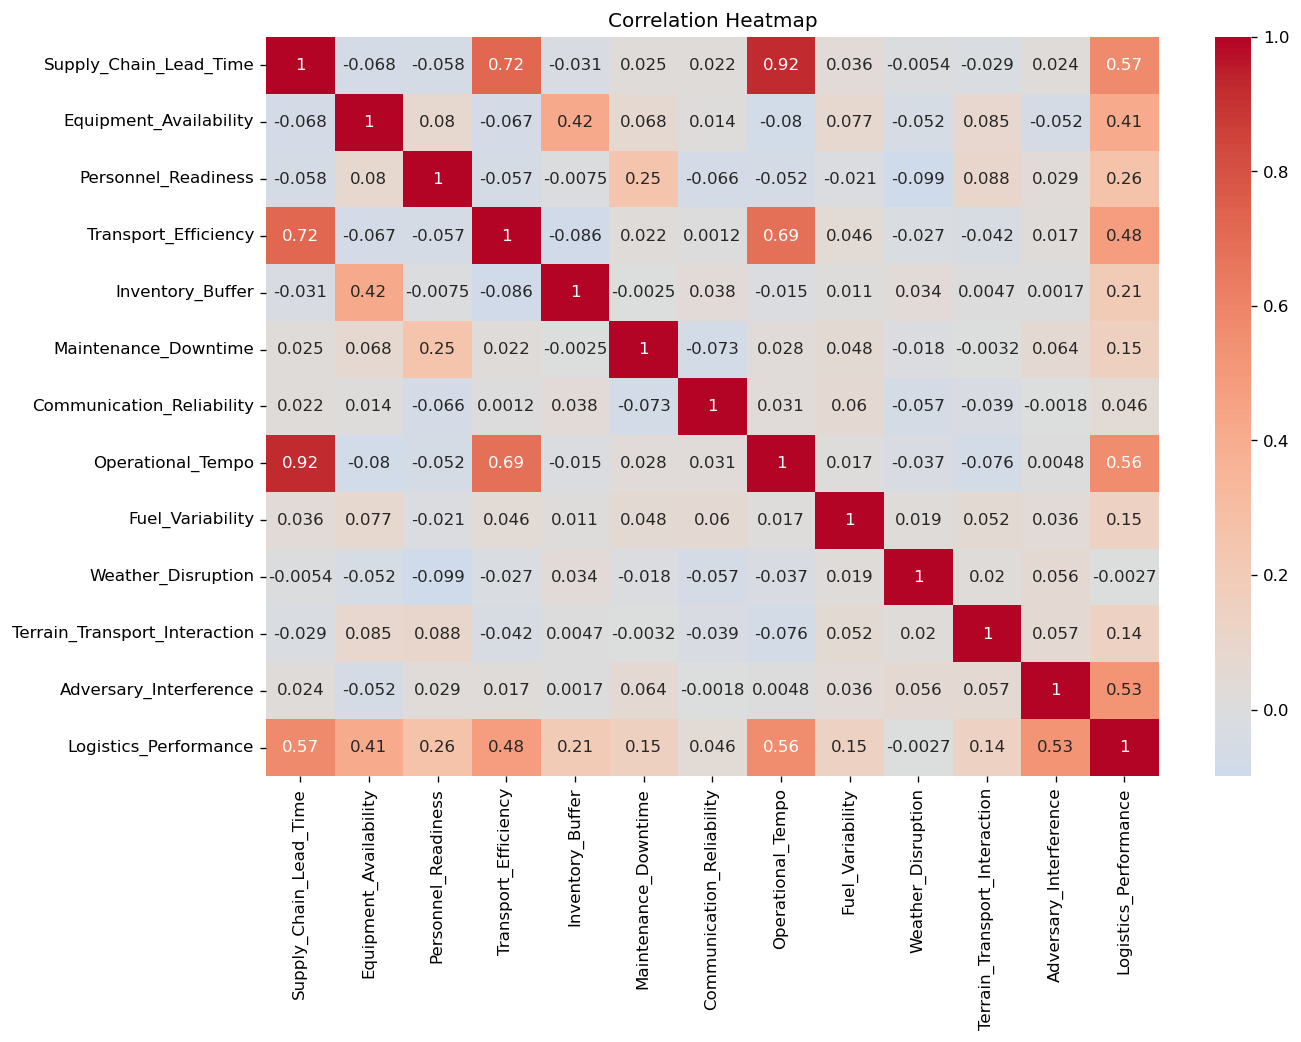

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Correlation matrix
corr = df.corr()

plt.figure(figsize=(12,8))
sns.heatmap(corr, annot=True, cmap="coolwarm", center=0)
plt.title("Correlation Heatmap")
plt.show()



## 2) Model, Loss, and Metrics

For a single predictor \(x\), simple linear regression is:
$$
\hat{y} = \beta_0 + \beta_1 x.
$$

We estimate parameters by minimizing **MSE**:
$$
\mathcal{L}(\boldsymbol{\beta}) = \frac{1}{n} \sum_{i=1}^{n} (y_i - \hat{y}_i)^2.
$$

**Metrics** used throughout:
- $$(\textbf{MSE} = \frac{1}{n} \sum_i (y_i-\hat{y}_i)^2)$$
- $$(\textbf{RMSE} = \sqrt{\text{MSE}})$$
- $$(\textbf{MAE} = \frac{1}{n} \sum_i \lvert y_i-\hat{y}_i \rvert)$$
- $$(\textbf{R}^2 = 1 - \frac{\sum_i (y_i-\hat{y}_i)^2}{\sum_i (y_i-\bar{y})^2})$$


In [ ]:

def evaluate(y_true, y_pred):
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    return dict(MSE=mse, RMSE=rmse, MAE=mae, R2=r2)

def plot_pred_vs_actual(y_true, y_pred, title="Predicted vs Actual"):
    plt.figure(figsize=(4,4))
    plt.scatter(y_true, y_pred, s=18)
    lims = [min(y_true.min(), y_pred.min()), max(y_true.max(), y_pred.max())]
    plt.plot(lims, lims)
    plt.xlabel("Actual")
    plt.ylabel("Predicted")
    plt.title(title)
    plt.grid(ls=':')
    plt.tight_layout()
    plt.show()

def plot_residuals(y_true, y_pred, title="Residuals vs Predicted"):
    resid = y_true - y_pred
    plt.figure(figsize=(4,4))
    plt.scatter(y_pred, resid, s=18)
    plt.axhline(0)
    plt.xlabel("Predicted")
    plt.ylabel("Residual (Actual - Predicted)")
    plt.title(title)
    plt.grid(ls=':')
    plt.tight_layout()
    plt.show()


In [ ]:
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)
y_tr = train_df[target].values
y_te = test_df[target].values
features = [c for c in df.columns if c != target]

# Helper: single best predictor by correlation (train only to avoid leakage)
corr_train = train_df[features + [target]].corr()[target].drop(target).abs().sort_values(ascending=False)
best1 = corr_train.index[0]



## 3) Part A — **Simple Linear Regression**

We pick the **best single predictor** by train‑set correlation with the target and fit $( \hat{y} = \beta_0 + \beta_1 x)$.


Best single predictor: Operational_Tempo

Train metrics: {'MSE': 215691.52985924692, 'RMSE': 464.4260219445578, 'MAE': 378.52138410757334, 'R2': 0.3398580955947301}
Test metrics: {'MSE': 306244.12073993677, 'RMSE': 553.3932785460415, 'MAE': 425.02839657372215, 'R2': 0.21909442724450845}


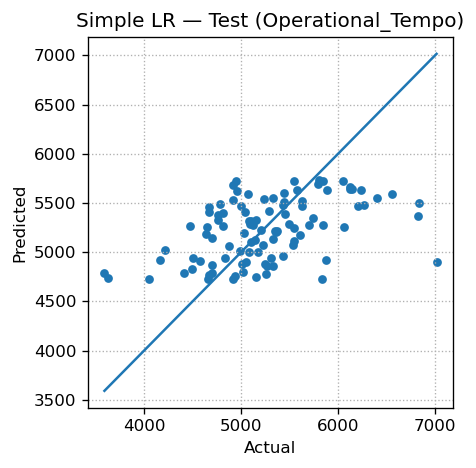

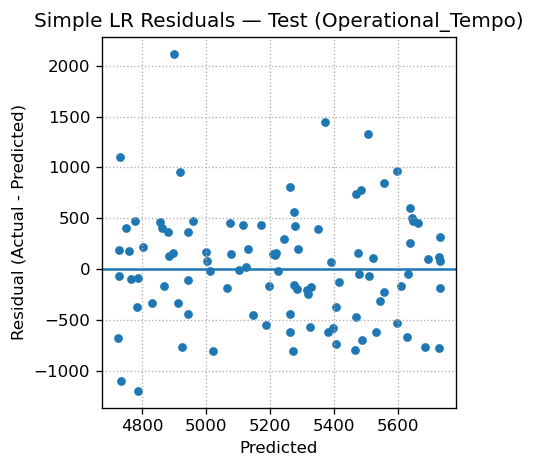

In [ ]:
X_tr_1 = train_df[[best1]].values
X_te_1 = test_df[[best1]].values

lr1 = LinearRegression().fit(X_tr_1, y_tr)
y_tr_hat = lr1.predict(X_tr_1)
y_te_hat = lr1.predict(X_te_1)

metrics_tr_1 = evaluate(y_tr, y_tr_hat)
metrics_te_1 = evaluate(y_te, y_te_hat)

print(f"Best single predictor: {best1}\n")
print("Train metrics:", metrics_tr_1)
print("Test metrics:", metrics_te_1)

plot_pred_vs_actual(y_te, y_te_hat, title=f"Simple LR — Test ({best1})")
plot_residuals(y_te, y_te_hat, title=f"Simple LR Residuals — Test ({best1})")



## 4) Part B — **Two‑Variable Linear Regression**

We add a second predictor that is strongly associated with the target but not highly collinear with the first (heuristic: pairwise |corr| < 0.85 on the train set).


Chosen predictors: ['Operational_Tempo', 'Adversary_Interference']
Train metrics (2‑var): {'MSE': 129581.47473887529, 'RMSE': 359.9742695511379, 'MAE': 280.0845886405048, 'R2': 0.6034050963170112}
Test metrics (2‑var): {'MSE': 186901.27803241077, 'RMSE': 432.32080453340524, 'MAE': 333.3510382665481, 'R2': 0.5234120765551737}


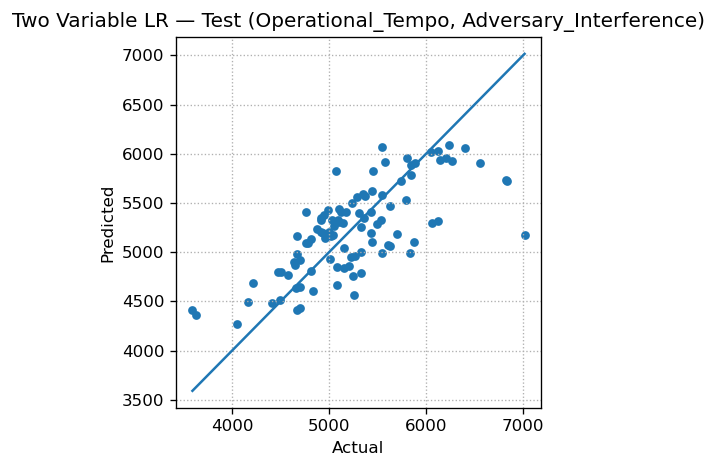

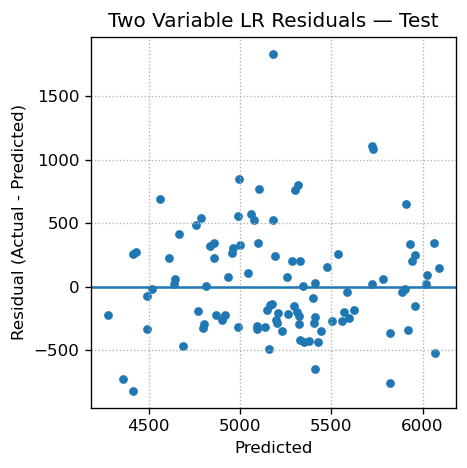

In [ ]:
candidates = corr_train.index.tolist()
first = candidates[0]
second = None
for cand in candidates[1:]:
    pcorr = abs(train_df[[first, cand]].corr().loc[first, cand])
    if pcorr < 0.85:
        second = cand
        break
if second is None:
    second = candidates[1]

best2 = [first, second]
print("Chosen predictors:", best2)

X_tr_2 = train_df[best2].values
X_te_2 = test_df[best2].values

lr2 = LinearRegression().fit(X_tr_2, y_tr)
y_tr_hat2 = lr2.predict(X_tr_2)
y_te_hat2 = lr2.predict(X_te_2)

metrics_tr_2 = evaluate(y_tr, y_tr_hat2)
metrics_te_2 = evaluate(y_te, y_te_hat2)

print("Train metrics (2-var):", metrics_tr_2)
print("Test metrics (2-var):", metrics_te_2)

plot_pred_vs_actual(y_te, y_te_hat2, title=f"Two Variable LR — Test ({best2[0]}, {best2[1]})")
plot_residuals(y_te, y_te_hat2, title="Two Variable LR Residuals — Test")



## 5) Part C — **Multiple Linear Regression (All Predictors)**

Let, $(\boldsymbol{x}_i \in \mathbb{{R}}^p)$. The MLR model is:
$$
\hat{y}_i = \beta_0 + \sum_{j=1}^{p} \beta_j x_{ij}.
$$
We fit ordinary least squares on the full feature set.


Train metrics (ALL): {'MSE': 26572.58520017022, 'RMSE': 163.01099717555934, 'MAE': 128.23142201252134, 'R2': 0.9186723882460346}
Test metrics (ALL): {'MSE': 31095.40264287061, 'RMSE': 176.33888579343642, 'MAE': 140.2204737903689, 'R2': 0.920708442819334}


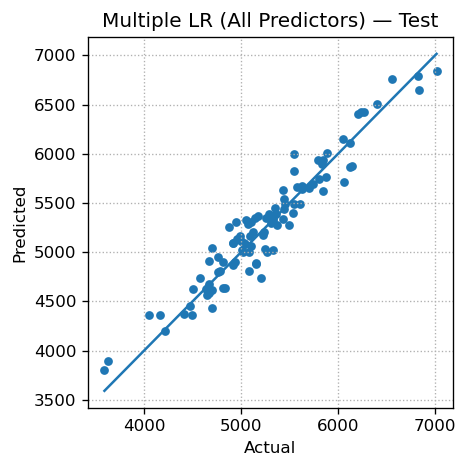

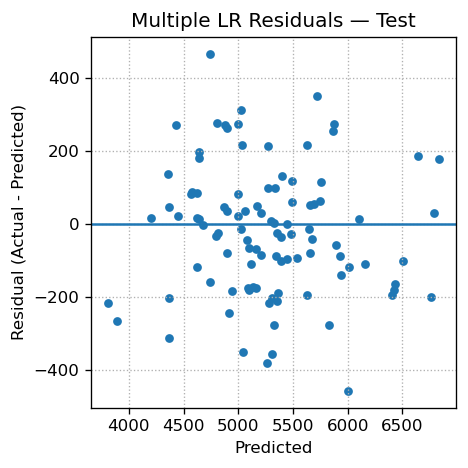

In [ ]:
X_tr_all = train_df[features].values
X_te_all = test_df[features].values

lr_all = LinearRegression().fit(X_tr_all, y_tr)
y_tr_hat_all = lr_all.predict(X_tr_all)
y_te_hat_all = lr_all.predict(X_te_all)

metrics_tr_all = evaluate(y_tr, y_tr_hat_all)
metrics_te_all = evaluate(y_te, y_te_hat_all)

print("Train metrics (ALL):", metrics_tr_all)
print("Test metrics (ALL):", metrics_te_all)

plot_pred_vs_actual(y_te, y_te_hat_all, title="Multiple LR (All Predictors) — Test")
plot_residuals(y_te, y_te_hat_all, title="Multiple LR Residuals — Test")



## 6) Ridge Regression (L2 Regularization)

We standardize features and use **RidgeCV** to select $(\alpha)$ from a grid via cross‑validation.  
Ridge minimizes
$$
\frac{1}{n}\sum_i (y_i-\hat{y}_i)^2 + \alpha \lVert \boldsymbol{\beta} \rVert_2^2.
$$


Best alpha (RidgeCV): 1.7782794100389228
Test metrics (Ridge): {'MSE': 30845.313817235263, 'RMSE': 175.62834001730832, 'MAE': 139.38406922145026, 'R2': 0.9213461554949296}


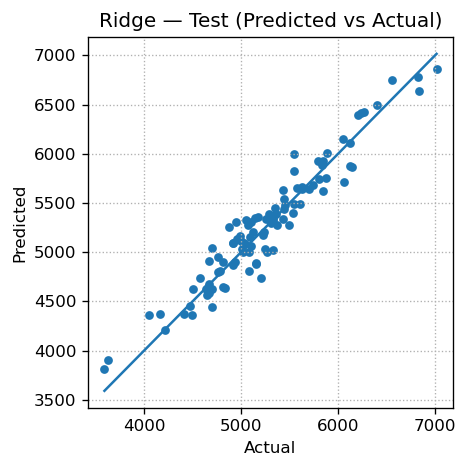

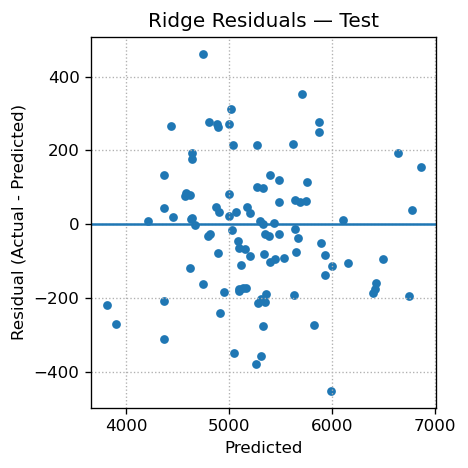

In [ ]:
alphas = np.logspace(-3, 3, 25)
ridge = Pipeline([
    ("scaler", StandardScaler()),
    ("model", RidgeCV(alphas=alphas, store_cv_values=False))
])
ridge.fit(train_df[features], y_tr)
y_te_ridge = ridge.predict(test_df[features])

ridge_alpha = ridge.named_steps["model"].alpha_
ridge_metrics = evaluate(y_te, y_te_ridge)

print("Best alpha (RidgeCV):", ridge_alpha)
print("Test metrics (Ridge):", ridge_metrics)

plot_pred_vs_actual(y_te, y_te_ridge, title="Ridge — Test (Predicted vs Actual)")
plot_residuals(y_te, y_te_ridge, title="Ridge Residuals — Test")



## 7) Lasso Regression (L1 Regularization)

We standardize features and use **LassoCV** with a log‑spaced grid.  
Lasso minimizes
$$
\frac{1}{n}\sum_i (y_i-\hat{y}_i)^2 + \alpha \lVert \boldsymbol{\beta} \rVert_1,
$$
which can drive some coefficients exactly to zero (implicit feature selection).


Best alpha (LassoCV): 0.001
Test metrics (Lasso): {'MSE': 31095.11387181354, 'RMSE': 176.33806699579515, 'MAE': 140.2195301938482, 'R2': 0.9207091791695605}


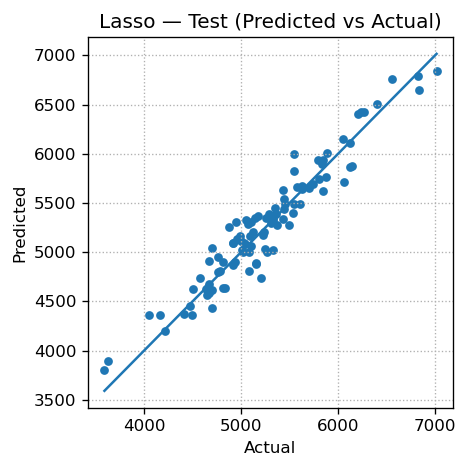

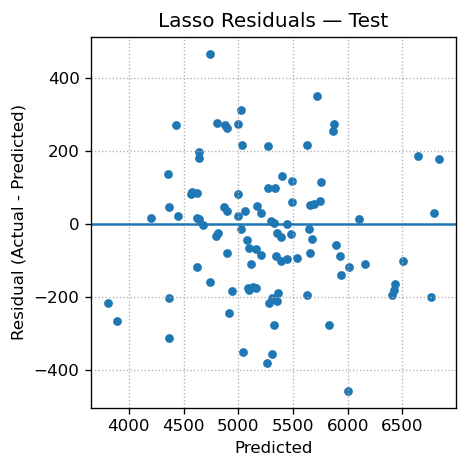

In [ ]:

lasso = Pipeline([
    ("scaler", StandardScaler()),
    ("model", LassoCV(alphas=np.logspace(-3, 1, 40), cv=5, max_iter=5000, random_state=42))
])
lasso.fit(train_df[features], y_tr)
y_te_lasso = lasso.predict(test_df[features])

lasso_alpha = lasso.named_steps["model"].alpha_
lasso_metrics = evaluate(y_te, y_te_lasso)

print("Best alpha (LassoCV):", lasso_alpha)
print("Test metrics (Lasso):", lasso_metrics)

plot_pred_vs_actual(y_te, y_te_lasso, title="Lasso — Test (Predicted vs Actual)")
plot_residuals(y_te, y_te_lasso, title="Lasso Residuals — Test")



## 8) Side‑by‑Side Comparison (Test Set)

We summarize **Single**, **Double**, **Multiple**, **Ridge**, and **Lasso** on the same split.


In [ ]:
compare = pd.DataFrame([
    {"Model":"Single",   **metrics_te_1},
    {"Model":"Double",   **metrics_te_2},
    {"Model":"Multiple", **metrics_te_all},
    {"Model":"Ridge",    **ridge_metrics},
    {"Model":"Lasso",    **lasso_metrics},
]).set_index("Model")
compare


,MSE,RMSE,MAE,R2
Model,,,,
Single,306244.120740,553.393279,425.028397,0.219094
Double,186901.278032,432.320805,333.351038,0.523412
Multiple,31095.402643,176.338886,140.220474,0.920708
Ridge,30845.313817,175.628340,139.384069,0.921346
Lasso,31095.113872,176.338067,140.219530,0.920709


## Effect of increasing multicollinearity on model performance.

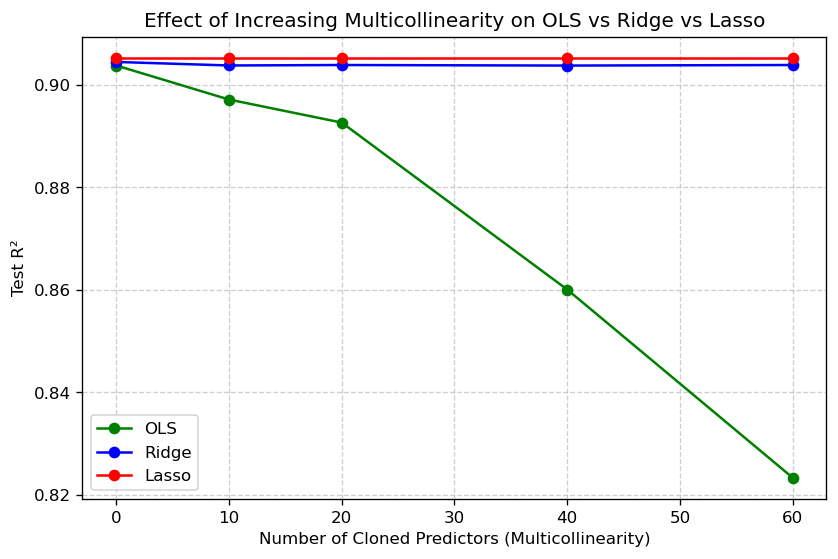

In [ ]:
# =====================================
# Effect of Increasing Multicollinearity on Model Performance
# =====================================
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, RidgeCV, LassoCV
from sklearn.metrics import r2_score
from sklearn.preprocessing import StandardScaler
import warnings
from sklearn.exceptions import ConvergenceWarning

# Suppress warnings for Lasso convergence
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=ConvergenceWarning)

# Load dataset
df = pd.read_csv("defense_logistics_dataset.csv")

# Range of clone counts to simulate multicollinearity
clone_counts = [0, 10, 20, 40, 60]
ols_scores, ridge_scores, lasso_scores = [], [], []

scaler = StandardScaler()

for n_clones in clone_counts:
    df_temp = df.copy()
    
    # Add near-perfect clones of Supply_Chain_Lead_Time
    for i in range(n_clones):
        df_temp[f"Clone_{i+1}"] = (
            df_temp["Supply_Chain_Lead_Time"] * (1 + 1e-4*np.random.randn(len(df_temp)))
        )
    
    # Define predictors and target
    X = df_temp.drop(columns=["Logistics_Performance"]).values
    y = df_temp["Logistics_Performance"].values
    
    # Train/test split
    X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.3, random_state=42)
    
    # Scale features (important for Lasso/Ridge)
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)

    # Fit models
    ols = LinearRegression().fit(X_train, y_train)
    ridge = RidgeCV(alphas=np.logspace(-3, 3, 20), cv=3).fit(X_train, y_train)
    lasso = LassoCV(alphas=np.logspace(-3, 1, 20), cv=3, max_iter=20000).fit(X_train, y_train)
    
    # Predictions
    y_pred_ols = ols.predict(X_test)
    y_pred_ridge = ridge.predict(X_test)
    y_pred_lasso = lasso.predict(X_test)
    
    # Store test R²
    ols_scores.append(r2_score(y_test, y_pred_ols))
    ridge_scores.append(r2_score(y_test, y_pred_ridge))
    lasso_scores.append(r2_score(y_test, y_pred_lasso))

# --- Plot ---
plt.figure(figsize=(8,5))
plt.plot(clone_counts, ols_scores, "-o", label="OLS", color="green")
plt.plot(clone_counts, ridge_scores, "-o", label="Ridge", color="blue")
plt.plot(clone_counts, lasso_scores, "-o", label="Lasso", color="red")
plt.xlabel("Number of Cloned Predictors (Multicollinearity)")
plt.ylabel("Test R²")
plt.title("Effect of Increasing Multicollinearity on OLS vs Ridge vs Lasso")
plt.legend()
plt.grid(True, linestyle="--", alpha=0.6)
plt.show()


In [ ]:
alphas

array([1.00000000e-03, 1.32571137e-03, 1.75751062e-03, 2.32995181e-03,
       3.08884360e-03, 4.09491506e-03, 5.42867544e-03, 7.19685673e-03,
       9.54095476e-03, 1.26485522e-02, 1.67683294e-02, 2.22299648e-02,
       2.94705170e-02, 3.90693994e-02, 5.17947468e-02, 6.86648845e-02,
       9.10298178e-02, 1.20679264e-01, 1.59985872e-01, 2.12095089e-01,
       2.81176870e-01, 3.72759372e-01, 4.94171336e-01, 6.55128557e-01,
       8.68511374e-01, 1.15139540e+00, 1.52641797e+00, 2.02358965e+00,
       2.68269580e+00, 3.55648031e+00, 4.71486636e+00, 6.25055193e+00,
       8.28642773e+00, 1.09854114e+01, 1.45634848e+01, 1.93069773e+01,
       2.55954792e+01, 3.39322177e+01, 4.49843267e+01, 5.96362332e+01,
       7.90604321e+01, 1.04811313e+02, 1.38949549e+02, 1.84206997e+02,
       2.44205309e+02, 3.23745754e+02, 4.29193426e+02, 5.68986603e+02,
       7.54312006e+02, 1.00000000e+03])

## Regularization (deeper)

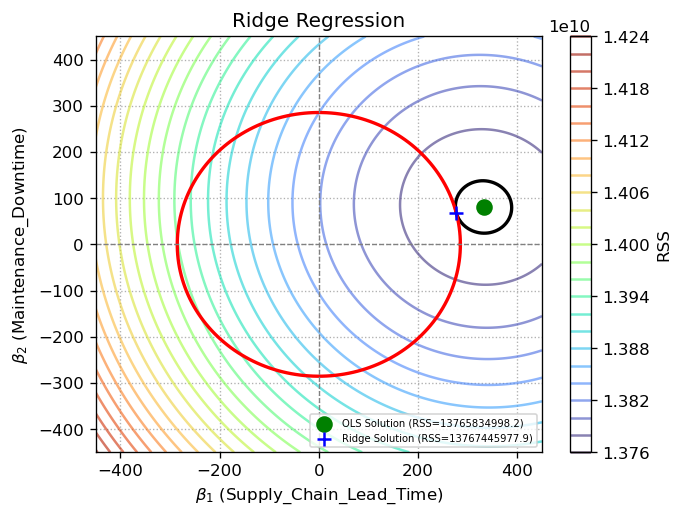

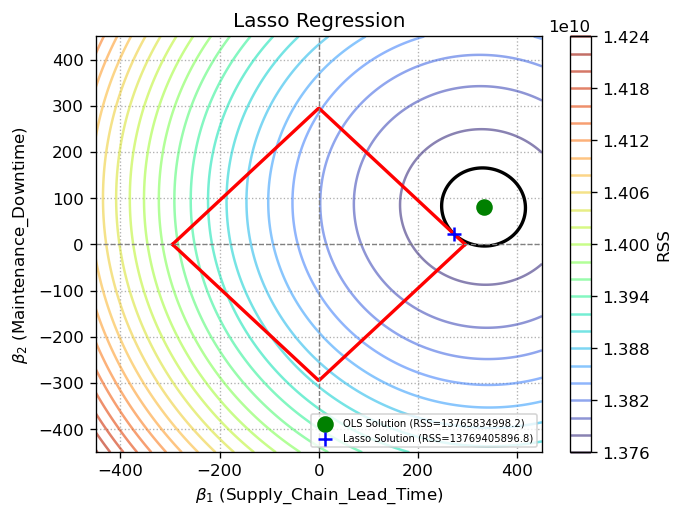

In [ ]:
# ==============================
# Ridge & Lasso Regression with Visualizations (Defense Logistics CSV)
# ==============================
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge, Lasso, LinearRegression

# Choose two predictors for 2D visualization
X_vars = ["Supply_Chain_Lead_Time", "Maintenance_Downtime"]
y_var = "Logistics_Performance"

# Standardize the two predictors
scaler = StandardScaler()
X2 = scaler.fit_transform(df[X_vars])
y2 = df[y_var].values

# Define grid for contours
num = 450
b1 = np.linspace(-num, num, 200)
b2 = np.linspace(-num, num, 200)
B1, B2 = np.meshgrid(b1, b2)

# Compute RSS over grid
RSS = np.zeros_like(B1)
for i in range(len(b1)):
    for j in range(len(b2)):
        y_hat_grid = B1[i, j] * X2[:, 0] + B2[i, j] * X2[:, 1]
        RSS[i, j] = np.sum((y2 - y_hat_grid) ** 2)

# --- Ridge
ridge = Ridge(alpha=100).fit(X2, y2)
beta_hat_ridge = ridge.coef_
y_hat_ridge = X2 @ beta_hat_ridge
rss_ridge = np.sum((y2 - y_hat_ridge) ** 2)

# OLS for reference
ols = LinearRegression().fit(X2, y2)
y_hat_ols = X2 @ ols.coef_
rss_ols = np.sum((y2 - y_hat_ols) ** 2)

# Visualize Ridge
plt.figure(figsize=(6, 4.5))
CS = plt.contour(B1, B2, RSS, levels=25, cmap="turbo", alpha=0.6)
plt.colorbar(CS, label="RSS")
plt.contour(B1, B2, RSS, levels=[rss_ridge], colors="black", linewidths=2)
ridge_radius = np.linalg.norm(beta_hat_ridge)
theta = np.linspace(0, 2 * np.pi, 200)
plt.plot(ridge_radius * np.cos(theta), ridge_radius * np.sin(theta), 'r-', lw=2)
plt.scatter(ols.coef_[0], ols.coef_[1], c="green", s=80, marker="o",
            label=f"OLS Solution (RSS={rss_ols:.1f})")
plt.scatter(beta_hat_ridge[0], beta_hat_ridge[1], c="blue", s=80, marker="+",
            label=f"Ridge Solution (RSS={rss_ridge:.1f})", zorder=3)
plt.axhline(0, color='grey', lw=0.8, ls='--')
plt.axvline(0, color='grey', lw=0.8, ls='--')
plt.legend(loc="lower right", fontsize=6)
plt.title("Ridge Regression")
plt.xlabel(r"$\beta_1$ (" + X_vars[0] + ")")
plt.ylabel(r"$\beta_2$ (" + X_vars[1] + ")")
plt.grid(ls=":")
plt.show()

# --- Lasso
lasso = Lasso(alpha=60.5, max_iter=10000).fit(X2, y2)
beta_hat_lasso = lasso.coef_
y_hat_lasso = X2 @ beta_hat_lasso
rss_lasso = np.sum((y2 - y_hat_lasso) ** 2)

# Visualize Lasso
plt.figure(figsize=(6, 4.5))
CS = plt.contour(B1, B2, RSS, levels=25, cmap="turbo", alpha=0.6)
plt.colorbar(CS, label="RSS")
plt.contour(B1, B2, RSS, levels=[rss_lasso], colors="black", linewidths=2)
lasso_t = np.sum(np.abs(beta_hat_lasso))
x = np.linspace(-lasso_t, lasso_t, 400)
plt.plot(x, (lasso_t - np.abs(x)), 'r-', lw=2)
plt.plot(x, -(lasso_t - np.abs(x)), 'r-', lw=2)
plt.scatter(ols.coef_[0], ols.coef_[1], c="green", s=80, marker="o",
            label=f"OLS Solution (RSS={rss_ols:.1f})")
plt.scatter(beta_hat_lasso[0], beta_hat_lasso[1], c="blue", s=80, marker="+",
            label=f"Lasso Solution (RSS={rss_lasso:.1f})", zorder=3)
plt.axhline(0, color='grey', lw=0.8, ls='--')
plt.axvline(0, color='grey', lw=0.8, ls='--')
plt.legend(loc="lower right", fontsize=6)
plt.title("Lasso Regression")
plt.xlabel(r"$\beta_1$ (" + X_vars[0] + ")")
plt.ylabel(r"$\beta_2$ (" + X_vars[1] + ")")
plt.grid(ls=":")
plt.show()


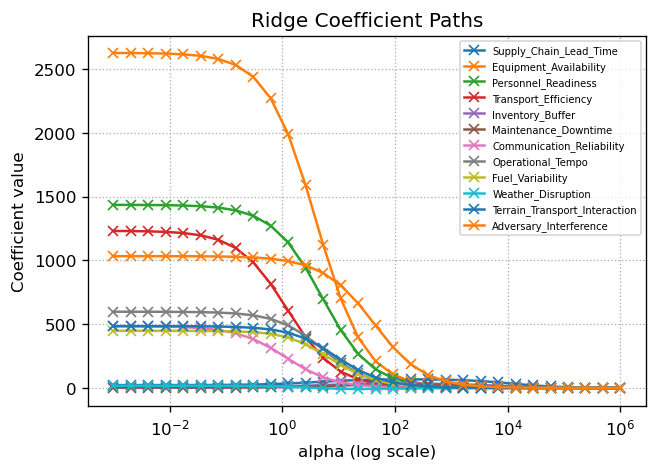

In [ ]:
# ==============================
# Ridge Coefficient Paths vs Alpha
# ==============================
import matplotlib.pyplot as plt
from sklearn.linear_model import Ridge

alphas = np.logspace(-3, 6, 30)   # wide range of alpha values
coefs = []

for a in alphas:
    ridge = Ridge(alpha=a, fit_intercept=True)
    ridge.fit(df[features], df[y_var])
    coefs.append(ridge.coef_)

coefs = np.array(coefs)

plt.figure(figsize=(6,4))
for i, col in enumerate(features):
    plt.plot(alphas, coefs[:, i], '-x', label=col)

plt.xscale('log')
plt.xlabel("alpha (log scale)")
plt.ylabel("Coefficient value")
plt.title("Ridge Coefficient Paths")
plt.legend(loc="best", fontsize=6)
plt.grid(ls=":")
plt.show()


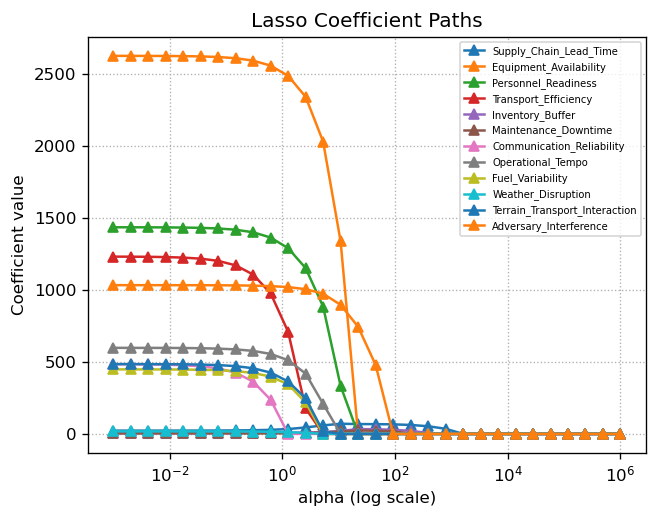

In [ ]:
# ==============================
# Lasso Coefficient Paths vs Alpha
# ==============================
import matplotlib.pyplot as plt
from sklearn.linear_model import Lasso

alphas = np.logspace(-3, 6, 30)   # Lasso needs smaller alpha range usually
coefs = []

for a in alphas:
    lasso = Lasso(alpha=a, fit_intercept=True, max_iter=10000)
    lasso.fit(df[features], df[y_var])
    coefs.append(lasso.coef_)

coefs = np.array(coefs)

plt.figure(figsize=(6,4))
for i, col in enumerate(features):
    plt.plot(alphas, coefs[:, i], '-^', label=col)

plt.xscale('log')
plt.xlabel("alpha (log scale)")
plt.ylabel("Coefficient value")
plt.title("Lasso Coefficient Paths")
plt.legend(loc="best", fontsize=6)
plt.grid(ls=":")
plt.show()


## Appreciating regularization better:

Modified dataset size: 22 predictors


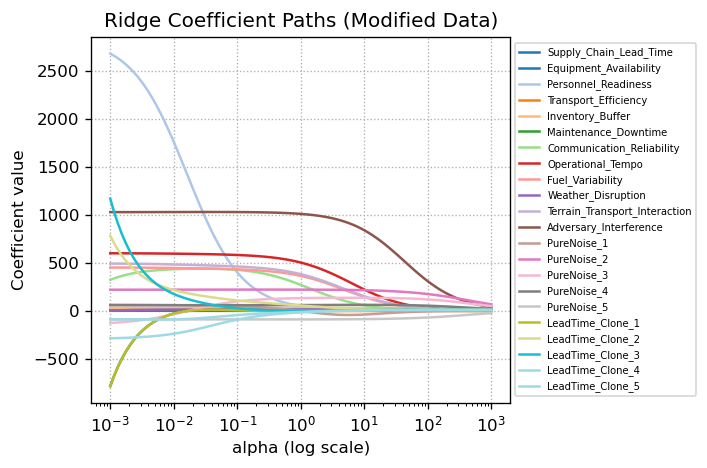

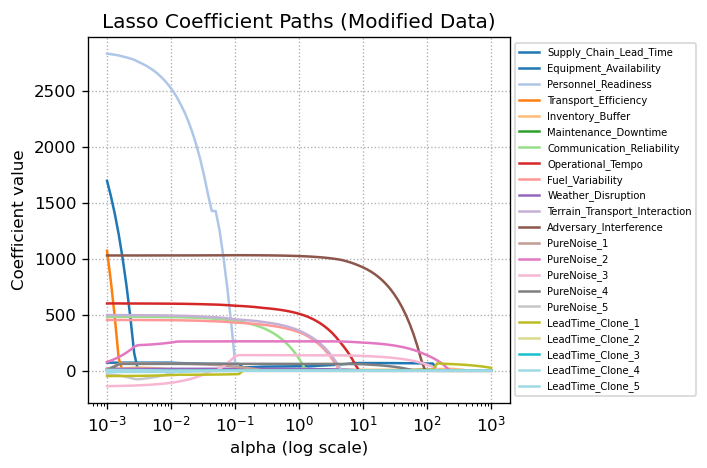

In [ ]:
# =====================================
# Stronger Ridge vs Lasso Demonstration
# =====================================
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import Ridge, Lasso
import matplotlib.cm as cm

import warnings
from sklearn.exceptions import ConvergenceWarning
warnings.filterwarnings("ignore", category=ConvergenceWarning)


# --- Modify dataset to highlight Ridge vs Lasso differences ---
df_mod = df.copy()
np.random.seed(42)

# 1) Add completely irrelevant noise predictors
for i in range(5):
    df_mod[f"PureNoise_{i+1}"] = np.random.randn(len(df_mod))

# 2) Add several correlated clones of one strong predictor
for i in range(5):
    df_mod[f"LeadTime_Clone_{i+1}"] = df_mod["Supply_Chain_Lead_Time"] + 0.01*np.random.randn(len(df_mod))

# # 3) Add a weak-signal predictor
# df_mod["Weak_Signal"] = 0.05 * df_mod["Supply_Chain_Lead_Time"] + np.random.randn(len(df_mod))

# Features and target
y_var = "Logistics_Performance"
features_mod = [c for c in df_mod.columns if c != y_var]
X = df_mod[features_mod].values
y = df_mod[y_var].values

print("Modified dataset size:", len(features_mod), "predictors")

# --- Ridge Coefficient Paths ---
alphas_ridge = np.logspace(-3, 3, 100)
coefs_ridge = []
for a in alphas_ridge:
    ridge = Ridge(alpha=a, fit_intercept=True)
    ridge.fit(X, y)
    coefs_ridge.append(ridge.coef_)
coefs_ridge = np.array(coefs_ridge)

# --- Ridge Coefficient Paths (with better colors & legend) ---
colors = cm.tab20(np.linspace(0, 1, len(features_mod)))

plt.figure(figsize=(6,4))
for i, col in enumerate(features_mod):
    plt.plot(alphas_ridge, coefs_ridge[:, i], label=col, color=colors[i])
plt.xscale('log')
plt.xlabel("alpha (log scale)")
plt.ylabel("Coefficient value")
plt.title("Ridge Coefficient Paths (Modified Data)")
plt.grid(ls=":")

# Put legend outside
plt.legend(loc="center left", bbox_to_anchor=(1, 0.5), fontsize=6)
plt.tight_layout()
plt.show()

# --- Lasso Coefficient Paths ---
alphas_lasso = np.logspace(-3, 3, 100)
coefs_lasso = []
for a in alphas_lasso:
    lasso = Lasso(alpha=a, fit_intercept=True, max_iter=10000)
    lasso.fit(X, y)
    coefs_lasso.append(lasso.coef_)
coefs_lasso = np.array(coefs_lasso)

# --- Lasso Coefficient Paths (with better colors & legend) ---
colors = cm.tab20(np.linspace(0, 1, len(features_mod)))

plt.figure(figsize=(6,4))
for i, col in enumerate(features_mod):
    plt.plot(alphas_lasso, coefs_lasso[:, i], label=col, color=colors[i])
plt.xscale('log')
plt.xlabel("alpha (log scale)")
plt.ylabel("Coefficient value")
plt.title("Lasso Coefficient Paths (Modified Data)")
plt.grid(ls=":")

# Put legend outside
plt.legend(loc="center left", bbox_to_anchor=(1, 0.5), fontsize=6)
plt.tight_layout()
plt.show()



### Discussion & Guidance

- **Generalization**: Prefer the model with better **test $(R^2)$** and lower **RMSE/MAE**.  
- **Bias–Variance**: If Multiple LR overfits, Ridge/Lasso often stabilize predictions.  
- **Interpretability**: Lasso may zero‑out coefficients, highlighting the most impactful drivers (e.g., *Supply_Chain_Lead_Time*, *Maintenance_Downtime*).  
- **Next Steps**: Consider interaction terms, non‑linear features, regularized models with grouped features, or domain‑guided feature engineering to capture logistics nuances (terrain, weather, adversary effects).
